### Land mine classifier

Author: Taha Parsayan
Date: 2025 Jan 07

Make a vertual environment

python -m venv packages

Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass

.\packages\Scripts\Activate.ps1

python.exe -m pip install --upgrade pip
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/

In [7]:
# Importing Libraries
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd
import shutil
import glob
import Land_mine_data_management_functions as dmf
from PIL import Image
from torch.utils.data import DataLoader
from Functions import data_setup, engine, model_builder, predictions
import random
from pathlib import Path
from torchinfo import summary
import torch.multiprocessing as mp
from Functions.helper_functions import plot_loss_curves
from torchvision.transforms.functional import InterpolationMode
from Functions.data_setup import create_dataloaders


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print('Using device:', device)


Using device: cpu


### Inspect the existing data

In [ ]:
current_path = os.getcwd()
folder_path = 'DatainBrief_dataset_1'
folder_path = os.path.join(current_path, folder_path)

def walk_through_directory(path):
    for root, dirs, files in os.walk(path):
        print(f"Root folder: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files: {files}")
        print("-" * 40)

data_path = os.path.join(current_path, 'data')
walk_through_directory(data_path)

### Prepare the data

There are 5 folders containing images of landmines. 
We take 4 of them for training and 1 for testing.

In [3]:
import os
import Land_mine_data_management_functions as dmf

# 5-Class Landmine Types
landmine_types = [
    "Free zone",
    "Mine 0cm depth",
    "Mine 1cm depth",
    "Mine 5cm depth",
    "Mine 10cm depth"
]

train_date_folders = ["03_03_2020",
                      "13_02_2020", 
                      "17_02_2020",
                      "20_02_2020"]

test_date_folders = ["24_02_2020"]

# 5-Class Folders
train_data_path_phase_3 = os.path.join(current_path, 'data', 'land_mine_phase_3', 'train')
test_data_path_phase_3 = os.path.join(current_path, 'data', 'land_mine_phase_3', 'test')
dmf.create_landmine_folders_phase_3(train_data_path_phase_3, landmine_types)
dmf.copy_images_to_landmine_folders_phase_3(folder_path, train_data_path_phase_3, landmine_types, train_date_folders)
dmf.create_landmine_folders_phase_3(test_data_path_phase_3, landmine_types)
dmf.copy_images_to_landmine_folders_phase_3(folder_path, test_data_path_phase_3, landmine_types, test_date_folders)


three_class_types = {
    "Surface": ["Mine 0cm depth", "Mine 1cm depth"],
    "Deep": ["Mine 5cm depth", "Mine 10cm depth"]
}
train_data_path_phase_2 = os.path.join(current_path, 'data', 'land_mine_phase_2', 'train')
test_data_path_phase_2 = os.path.join(current_path, 'data', 'land_mine_phase_2', 'test')
dmf.create_landmine_folders_phase_2(train_data_path_phase_2, three_class_types)
dmf.copy_images_to_landmine_folders_phase_2(folder_path, train_data_path_phase_2, three_class_types, train_date_folders)
dmf.create_landmine_folders_phase_2(test_data_path_phase_2, three_class_types)
dmf.copy_images_to_landmine_folders_phase_2(folder_path, test_data_path_phase_2, three_class_types, test_date_folders)

# 2-Class Landmine Types
two_class_types = {
    "Free zone": ["Free zone"],
    "Land_mine": ["Mine 0cm depth", "Mine 1cm depth", "Mine 5cm depth", "Mine 10cm depth"]
}
train_data_path_phase_1 = os.path.join(current_path, 'data', 'land_mine_phase_1', 'train')
test_data_path_phase_1 = os.path.join(current_path, 'data', 'land_mine_phase_1', 'test')
dmf.create_landmine_folders_phase_1(train_data_path_phase_1, two_class_types)
dmf.copy_images_to_landmine_folders_phase_1(folder_path, train_data_path_phase_1, two_class_types, train_date_folders)
dmf.create_landmine_folders_phase_1(test_data_path_phase_1, two_class_types)
dmf.copy_images_to_landmine_folders_phase_1(folder_path, test_data_path_phase_1, two_class_types, test_date_folders)


### See the data
Show one random image from the data

Number of training images: 516
Number of testing images: 126


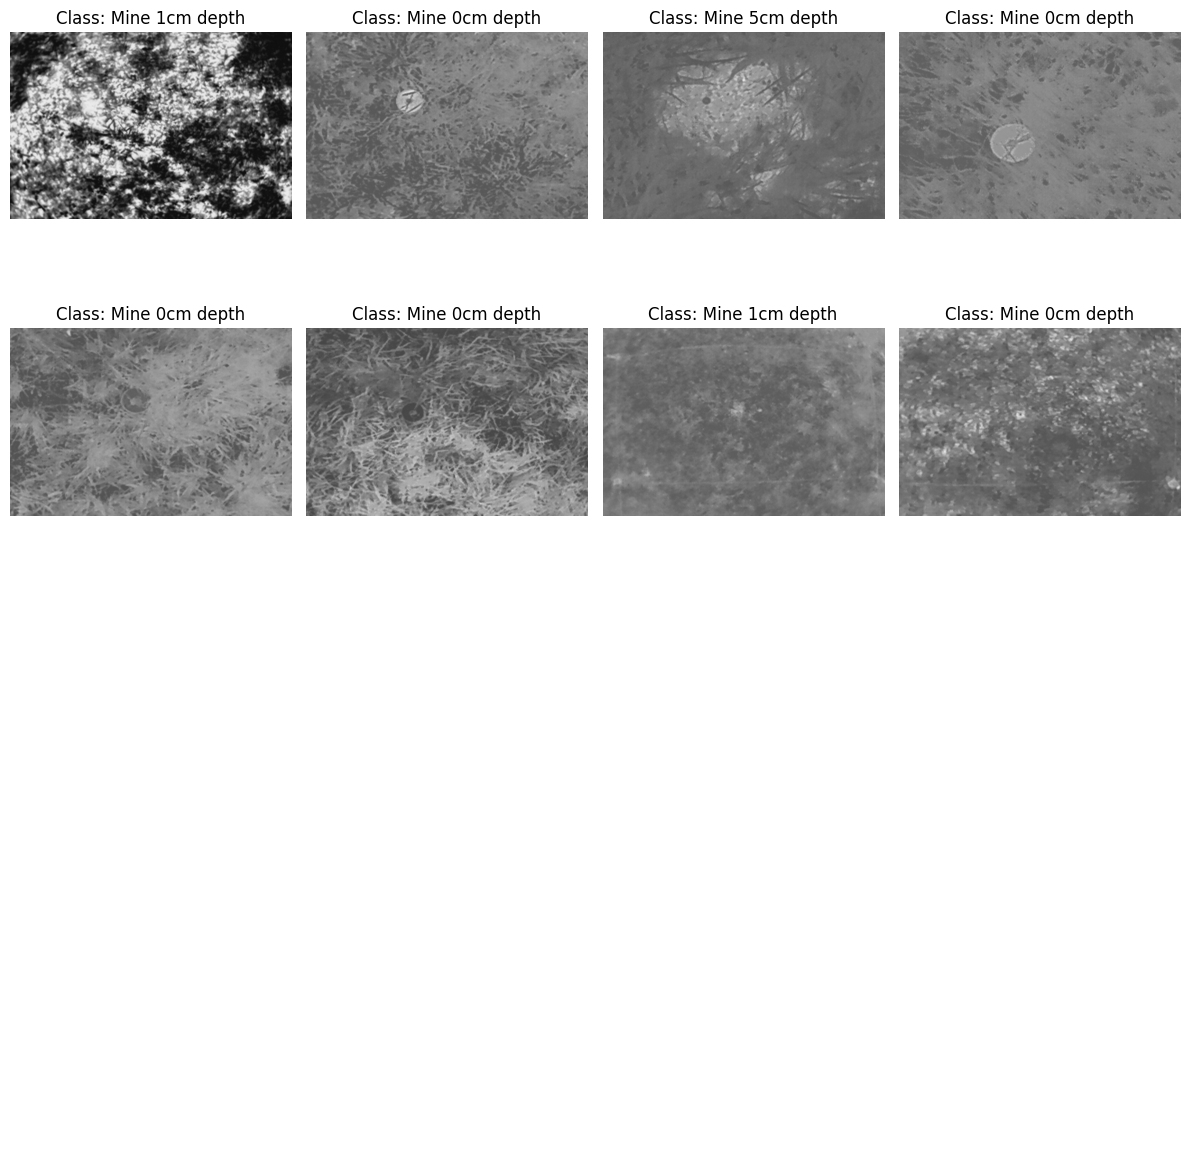

In [19]:
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(7)

# Paths to train and test datasets
train_data_path = Path(train_data_path_phase_3)
test_data_path = Path(test_data_path_phase_3)

# Get the list of image paths
train_image_path_list = list(train_data_path.glob("*/*.jpg"))
test_image_path_list = list(test_data_path.glob("*/*.jpg"))

print(f"Number of training images: {len(train_image_path_list)}")
print(f"Number of testing images: {len(test_image_path_list)}")

# Select 8 random images
random_image_paths = random.sample(train_image_path_list, 8)

# Create a 4x4 grid (only using the first 8 slots for images)
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Flatten axes for easier iteration
axes = axes.ravel()

for i, ax in enumerate(axes):
    if i < len(random_image_paths):  # For the first 8 axes
        image_path = random_image_paths[i]
        img = Image.open(image_path)
        image_class = image_path.parent.stem
        
        ax.imshow(img)
        ax.set_title(f"Class: {image_class}")
        ax.axis('off')
    else:  # Leave remaining slots blank
        ax.axis('off')

plt.tight_layout()
plt.show()


### Classification model
ViT classification model
Through transfer learning, we freeze the rest of the data and keep the head layer learnable.

In [ ]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Transfer learning
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)
# # Modify the first convolution layer to accept 1-channel (grayscale) input
# pretrained_vit.conv_proj = nn.Conv2d(
#     in_channels=3,  # Grayscale image (1 channel)
#     out_channels=768,  # Output channels
#     kernel_size=16,  # Same kernel size
#     stride=16  # Same stride
# ).to(device)

pretrained_vit.heads = nn.Sequential(
    nn.Dropout(p = 0.2),
    nn.Linear(in_features=768, out_features=2)
).to(device)

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(16, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

### Dataloader
Prepare the data for training and testing

In [ ]:
# Main dataset
batch_size = 16
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

# Augmentaed dataset to be added to the main dataset
augmentation_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors
    transforms.RandomHorizontalFlip(p=1),  # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.3),  # Random vertical flip
    transforms.RandomRotation(degrees=15, interpolation=InterpolationMode.BICUBIC),  # Random rotation
    transforms.Resize(size=256, interpolation=InterpolationMode.BILINEAR),  # Resize to 256
    transforms.CenterCrop(size=224),  # Center crop to 224x224
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(
        mean=pretrained_vit_weights.transforms().mean,
        std=pretrained_vit_weights.transforms().std  # Normalize with pretrained weights
    )
])

# Change data here for 2 class, 3 class, and 5 class

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_data_path_phase_1, 
    test_dir=test_data_path_phase_1,
    transform=pretrained_vit_transforms,
    batch_size=batch_size,
    augmentation_transform=augmentation_transform
)


print(' ')
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")

print(' ')
print("Number of training data: ", len(train_dataloader_pretrained) * batch_size)
print("Number of testing data: ", len(test_dataloader_pretrained) * batch_size)

# image_batch, label_batch = next(iter(train_dataloader_pretrained))
# print(image_batch.shape, label_batch.shape)

# image, label = image_batch[0], label_batch[0]
# print(image.shape, label)

# plt.imshow(image.permute(1, 2, 0))
# plt.title(class_names[label])
# plt.axis(False)

### Train the model

In [ ]:
# Check the device
print(f"Working on device: {device}")

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()


# Train the classifier head of the pretrained ViT feature extractor model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

pretrained_vit_results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=30,
    device=device
)


### Plot model performance

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### Plot ROC curve

In [ ]:
#from helper_functions import plot_roc_auc

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


def plot_roc_auc(model: torch.nn.Module, 
                 dataloader: torch.utils.data.DataLoader, 
                 device: torch.device) -> None:
    """
    Plots the ROC curve and calculates the AUC for a binary classification model.
    
    Parameters:
        model (torch.nn.Module): Trained PyTorch model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        device (torch.device): Device to perform computations on (e.g., "cuda" or "cpu").
    """
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_probs = []
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred_logits = model(X)
            
            # Convert logits to probabilities
            y_pred_probs = torch.softmax(y_pred_logits, dim=1)[:, 1]  # Probability of class 1
            
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(y_pred_probs.cpu().numpy())
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    auc = roc_auc_score(all_labels, all_probs)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()


plot_roc_auc(model=pretrained_vit, 
             dataloader=test_dataloader_pretrained, 
             device=device)

### Som plots


In [ ]:
patch_size = 16

image_batch, label_batch = next(iter(train_dataloader_pretrained))
print(image_batch.shape, label_batch.shape)

image, label = image_batch[0], label_batch[0]
print(image.shape, label)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

conv2d = nn.Conv2d(in_channels=3, 
                   out_channels=768, # 3 x 16 x 16 = 768
                   kernel_size=patch_size, 
                   stride=patch_size,
                   padding=0)

image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(12, 12))

for i, j in enumerate(range(10)):
    axs[i].imshow(image_out_of_conv[0, j].detach().numpy())
    axs[i].axis(False)


# Create flatten layer
#shape: (1, c, h, w)
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")
#[1, 768, 196] = [batch_size, embedding_dimension, number_of_patches]
#Should reshape to [batch_size, number_of_patches, embedding_dimension]
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);
